In [1]:
import gym
import torch.nn as nn
import torch 
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class Actor(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(3, 400)  # Input is of size 3 (observation space size)
        self.layer_2 = nn.Linear(400, 300)
        self.layer_3 = nn.Linear(300, 1)  # Output is 1-dimensional (action space)

    def forward(self, x):
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        return F.tanh(self.layer_3(x)) * 2  # Ensuring output is in range [-2, 2]


class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(4, 400)  # Input size should be 4 (state + action)
        self.layer_2 = nn.Linear(400, 300)
        self.layer_3 = nn.Linear(300, 1)  # Output is a single Q-value

    def forward(self, state, action):
        # Concatenate state and action
        x = torch.cat([state, action], dim=1)  # Concatenate along the correct dimension
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        return self.layer_3(x)

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
actor = Actor()
critic = Critic()
actor = actor.to(device)
critic = critic.to(device)

In [4]:
actor_optimizer = optim.RMSprop(actor.parameters(), lr=1e-4)
critic_optimizer = optim.RMSprop(critic.parameters(), lr = 1e-3)


In [5]:
target_actor = Actor().to(device)
target_critic = Critic().to(device)
target_actor.load_state_dict(actor.state_dict())
target_critic.load_state_dict(critic.state_dict())

<All keys matched successfully>

In [6]:
env = gym.make("Pendulum-v0")
state_space = env.observation_space.shape
action_space = env.action_space.shape
state_space, action_space

((3,), (1,))

In [7]:
class ReplayBuffer:
    def __init__(self, max_size, batch_size, state_space, action_space):
        self.max_size = max_size
        self.batch_size = batch_size
        self.counter = 0
        self.states = np.zeros((max_size, *state_space))
        self.actions = np.zeros((max_size, *action_space))
        self.next_states = np.zeros((max_size, *state_space))
        self.rewards = np.zeros(max_size)
        self.dones = np.zeros(max_size)

    def store(self, state, action, reward, next_state, done):
        idx = self.counter % self.max_size
        self.states[idx] = state
        self.actions[idx] = action
        self.rewards[idx] = reward
        self.next_states[idx] = next_state
        self.dones[idx] = done
        self.counter += 1

    def sample(self):
        max_index = min(self.max_size, self.counter)
        if max_index < self.batch_size:
            raise ValueError('Insufficient samples in buffer')
        indices = np.random.randint(0, max_index, size=self.batch_size)
        return (
            torch.tensor(self.states[indices]).float().to(device),
            torch.tensor(self.actions[indices]).float().to(device),
            torch.tensor(self.rewards[indices]).float().to(device),
            torch.tensor(self.next_states[indices]).float().to(device),
            torch.tensor(self.dones[indices]).float().to(device)
        )


In [8]:
def choose_action(state, actor, action_min=-2, action_max=2, exploration=True):
    state = torch.from_numpy(state).float().to(device)
    with torch.no_grad():
        if not exploration:
            return np.clip(actor(state).cpu().numpy(), action_min, action_max)
        else:
            return np.clip(actor(state).cpu().numpy() + (np.random.randn(*action_space)*sigma + mean), action_min, action_max)
            
    

In [9]:
tau = 1e-3
replay_buffer_size = int(1e5)
batch_size = 128
mean = 0.1
sigma = 0.2
gamma = 0.99
num_episodes = 1000
replay_buffer = ReplayBuffer(replay_buffer_size, batch_size, state_space, action_space)

In [10]:
scores = []
for episode in range(num_episodes):
    state = env.reset()
    score = 0
    done = False
    while not done:
        action = choose_action(state, actor)
        next_state, reward, done, _ = env.step(action)
        
        score += reward 
        replay_buffer.store(state, action, reward, next_state, int(done))
        state = next_state
        if replay_buffer.counter >= replay_buffer.batch_size:
            critic_optimizer.zero_grad()
            actor_optimizer.zero_grad()
            states, actions, rewards, next_states, dones = replay_buffer.sample()
            with torch.no_grad():
                next_state_actions = target_actor(next_states)
                target_q_values = target_critic(next_states, next_state_actions)
                critic_targets = rewards.view(-1, 1) + gamma*target_q_values*(1 - dones.view(-1, 1))
            critic_predictions = critic(states, actions)
            critic_loss = F.mse_loss(critic_predictions, critic_targets)
            critic_loss.backward()
            nn.utils.clip_grad_norm_(critic.parameters(), max_norm=1.0)
            critic_optimizer.step()

            actor_actions = actor(states)
            actor_loss = -critic(states, actor_actions).mean()
            actor_loss.backward()
            nn.utils.clip_grad_norm_(actor.parameters(), max_norm=1.0)
            actor_optimizer.step()
            for target_param, param in zip(target_critic.parameters(), critic.parameters()):
                target_param.data.copy_(tau*param.data + (1-tau)*target_param.data)

            for target_param, param in zip(target_actor.parameters(), actor.parameters()):
                target_param.data.copy_(tau*param.data + (1-tau)*target_param.data)
    print(f"Episode: {episode + 1}, Score:{score}")
    
    scores.append(score)
            
            
    
        
    

Episode: 1, Score:-1191.4111509508634
Episode: 2, Score:-1452.4159508413222
Episode: 3, Score:-1630.2128667667944
Episode: 4, Score:-1647.8282072643067
Episode: 5, Score:-1447.1628596968483
Episode: 6, Score:-1216.342292831405
Episode: 7, Score:-1507.8353946826003
Episode: 8, Score:-1575.391835818484
Episode: 9, Score:-1568.7314172871195
Episode: 10, Score:-1228.8287739261293
Episode: 11, Score:-1250.0817014378079
Episode: 12, Score:-1433.9790314849624
Episode: 13, Score:-1148.4128784267743
Episode: 14, Score:-1440.9675511042246
Episode: 15, Score:-1592.872627907958
Episode: 16, Score:-1572.2863542858418
Episode: 17, Score:-1147.8788600192408
Episode: 18, Score:-1343.624847533502
Episode: 19, Score:-1526.2403686196649
Episode: 20, Score:-1525.1463563181733
Episode: 21, Score:-1457.8573958044556
Episode: 22, Score:-650.0339118040617
Episode: 23, Score:-1538.0004956132857
Episode: 24, Score:-1187.1716638827124
Episode: 25, Score:-1292.1965444602126
Episode: 26, Score:-1569.759064810812
E

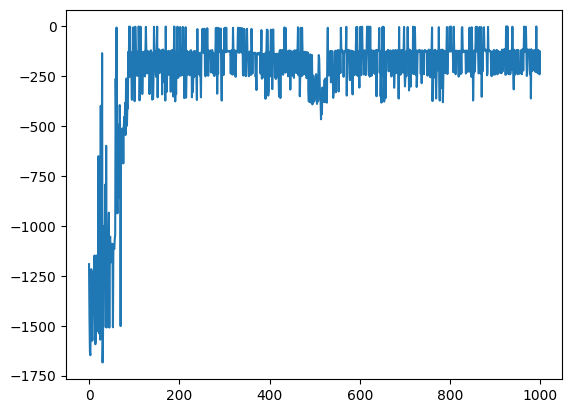

In [11]:
plt.plot(scores)
plt.show()

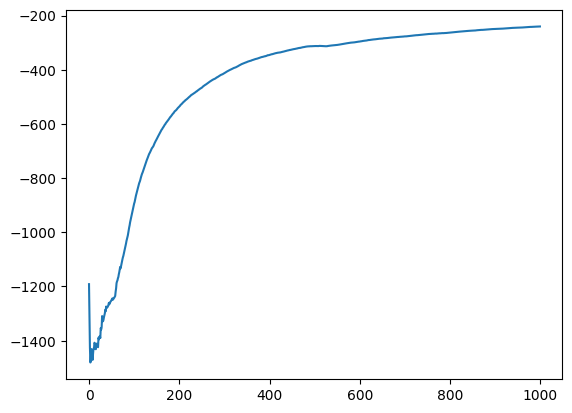

In [12]:
plt.plot(np.cumsum(scores)/(np.arange(len(scores))+1))
plt.show()

In [18]:
test_scores = []
for i in range(20):
    state = env.reset()
    done = False
    score = 0
    while not done:
        action = choose_action(state, actor, exploration=False)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        score += reward 
    test_scores.append(score)
    print(f'Epsiode Number: {i+1}, {score}')



Epsiode Number: 1, -2.2389524147110094
Epsiode Number: 2, -113.1331105650441
Epsiode Number: 3, -118.69891946429428
Epsiode Number: 4, -125.52099946760273
Epsiode Number: 5, -0.1486501980844722
Epsiode Number: 6, -223.73682851111133
Epsiode Number: 7, -124.48118270462508
Epsiode Number: 8, -231.04093501024684
Epsiode Number: 9, -216.0694139651957
Epsiode Number: 10, -0.24798054947865
Epsiode Number: 11, -119.55845342051623
Epsiode Number: 12, -230.61927710982567
Epsiode Number: 13, -118.63756023124448
Epsiode Number: 14, -121.26548291330056
Epsiode Number: 15, -230.49903597563022
Epsiode Number: 16, -115.78320385289501
Epsiode Number: 17, -116.96485530376476
Epsiode Number: 18, -0.5397058055441951
Epsiode Number: 19, -115.66132569027262
Epsiode Number: 20, -115.14209407975898


In [19]:
np.mean(test_scores)

np.float64(-121.99939836165731)